In [1]:
import numpy as np
import mne 
import scipy 
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [2]:
raw_data=mne.io.read_raw_brainvision('lj/NeoRec_2022-12-08_17-09-28.vhdr', preload=True)

Extracting parameters from lj/NeoRec_2022-12-08_17-09-28.vhdr...
Setting channel info structure...
Reading 0 ... 1575717  =      0.000 ...   787.859 secs...


In [3]:
raw_data.info

<Info | 7 non-empty values
 bads: []
 ch_names: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, x, y, z
 chs: 15 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: unspecified
 nchan: 15
 projs: []
 sfreq: 2000.0 Hz
>

In [4]:
raw_data.ch_names

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'x', 'y', 'z']

In [5]:
raw_data_acc=raw_data.copy().drop_channels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])

Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>


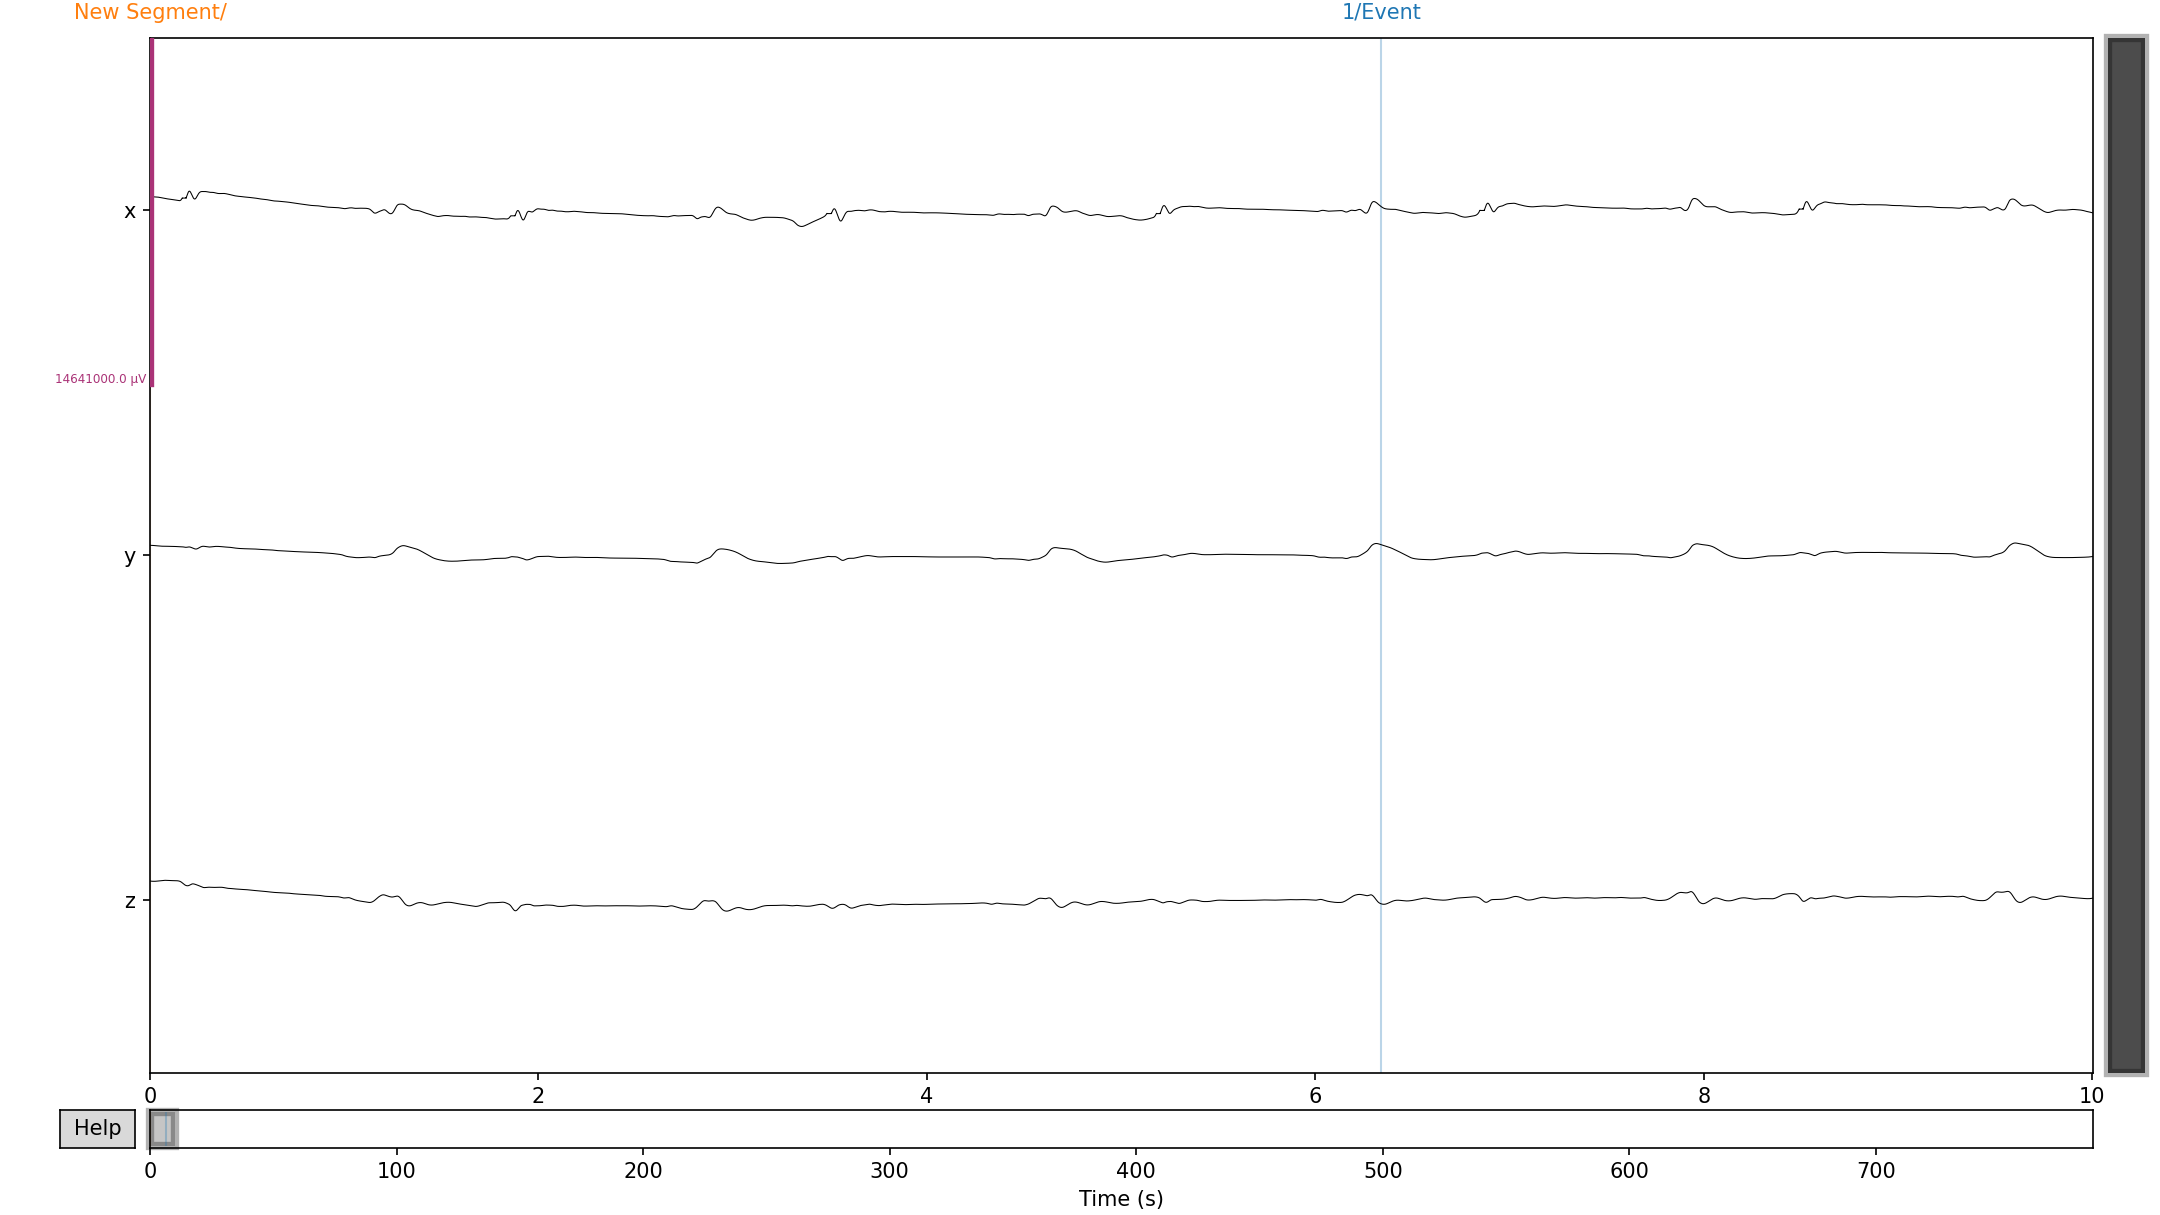

<function matplotlib.pyplot.show(block=None)>

In [6]:
raw_data_acc.plot(scalings={'eeg':0.5e1})
plt.show

In [12]:
xyz=raw_data_acc.get_data()


In [13]:
фаза - 3500

NameError: name 'фаза' is not defined

In [15]:
y_data=xyz[1,:]

In [20]:
out=np.convolve(y_data,xyz[1,5500-1000:5500+3500-1000], 'same')

<IPython.core.display.Javascript object>


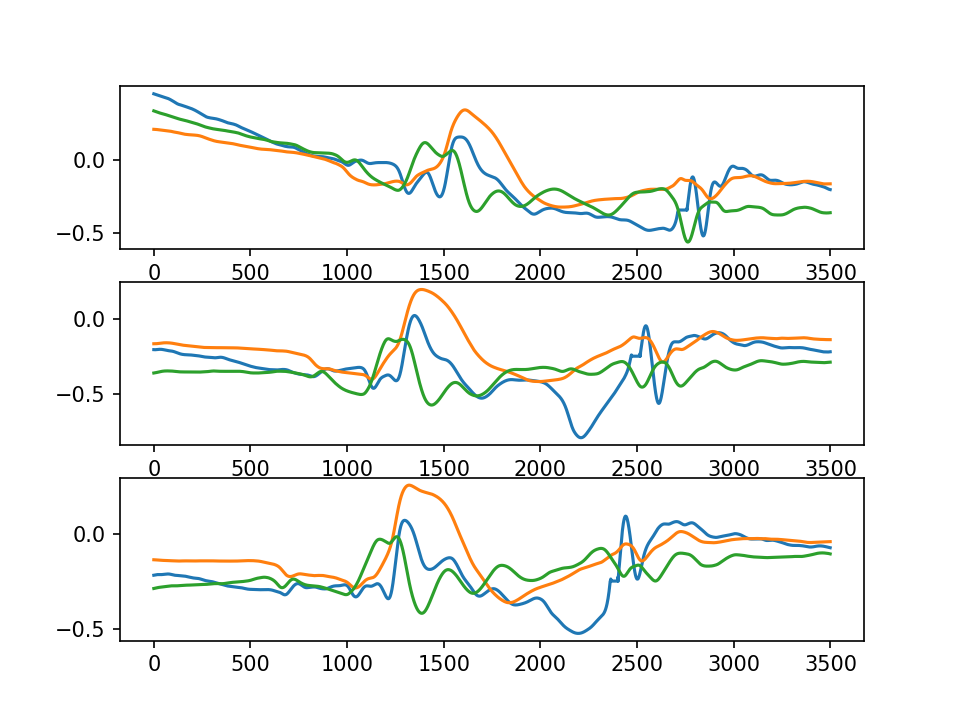

In [19]:
plt.close()

fig,ax=plt.subplots(3,1)
ax[0].plot(xyz[:,2000-1000:5500-1000].T)
ax[1].plot(xyz[:,5500-1000:5500+3500-1000].T)
ax[2].plot(xyz[:,9000-1000:9000+3500-1000].T)

In [21]:
out.shape

(1575718,)

<IPython.core.display.Javascript object>


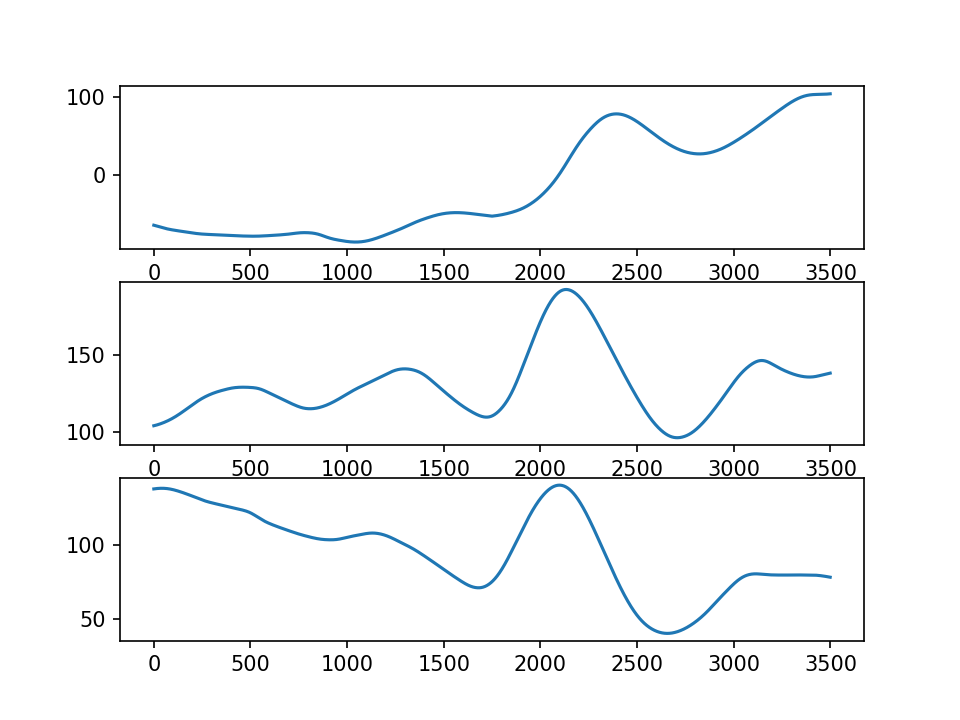

In [22]:
plt.close()

fig,ax=plt.subplots(3,1)
ax[0].plot(out[0:3500])
ax[1].plot(out[3500:7000])
ax[2].plot(out[7000:10500])

<IPython.core.display.Javascript object>


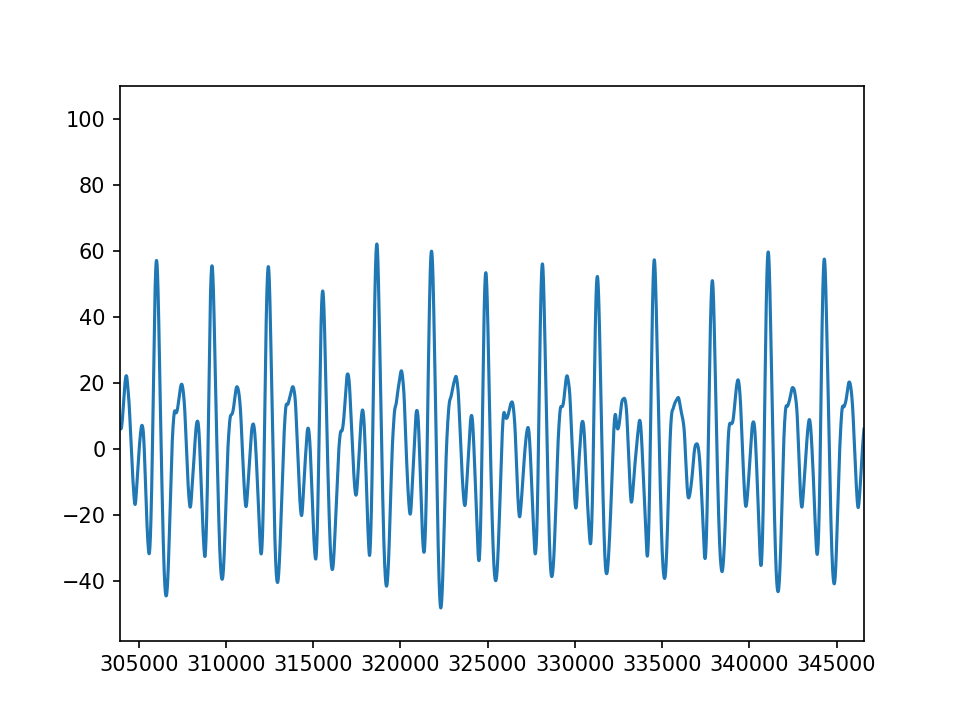

In [23]:
plt.close()
plt.plot(out)

In [24]:
def find_peaks(array_, koef=1.1, max_flg=False):

    mean_=np.mean(array_)
    std_=np.std(array_)

    max_=mean_+koef*std_
    min_=mean_-koef*std_

    max_array_=[max_]*len(array_)
    min_array_=[min_]*len(array_)

    inds=np.where(array_>max_)[0]
    
    if max_flg:
        return inds, max_
    
    else:
        return inds
    
    
def find_peaks_min(array_, koef=1.1, max_flg=False):

    mean_=np.mean(array_)
    std_=np.std(array_)

    max_=mean_+koef*std_
    min_=mean_-koef*std_

    max_array_=[max_]*len(array_)
    min_array_=[min_]*len(array_)

    inds=np.where(array_<min_)[0]
    
    if max_flg:
        return inds, min_
    
    else:
        return inds
    
def reduce_peaks(marks_array_inds,  threhold, with_log=False,):
    
    new_marks_array_inds=[marks_array_inds[0]]
    for i in range(1,len(marks_array_inds)):
        if marks_array_inds[i]-new_marks_array_inds[-1]<threhold:
            if with_log:
                print(i)
        else:
            new_marks_array_inds.append(marks_array_inds[i])

    return new_marks_array_inds


In [27]:
inds=find_peaks(out,1.3)

<IPython.core.display.Javascript object>


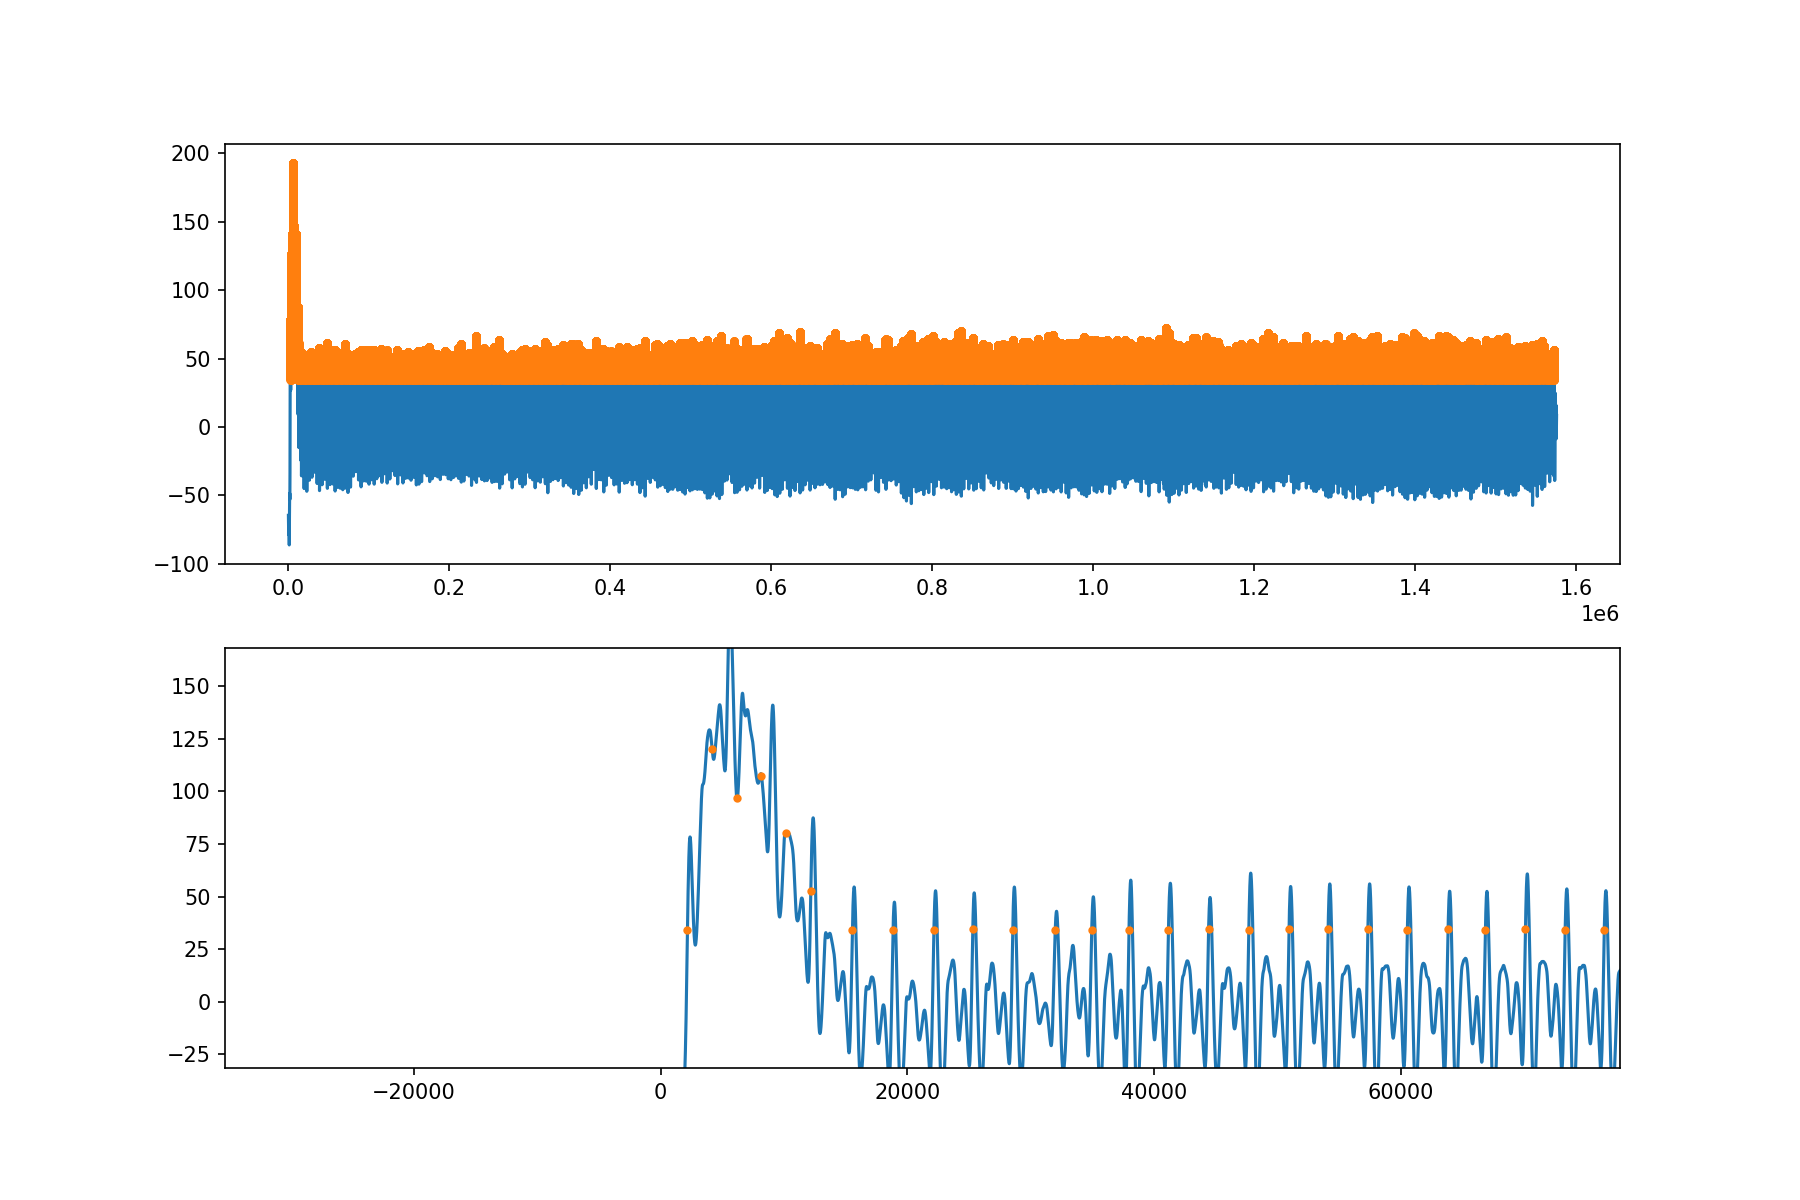

In [28]:
plt.close()
fig,ax=plt.subplots(2,1, figsize=(12,8))
ax[0].plot(out)
ax[0].plot(inds,out[inds], '.')

new_peaks=reduce_peaks(inds, 2000)
ax[1].plot(out)
ax[1].plot(new_peaks,out[new_peaks], '.')

In [29]:
events_max=new_peaks[5:]

In [34]:
inds=find_peaks_min(out,1.3)

<IPython.core.display.Javascript object>


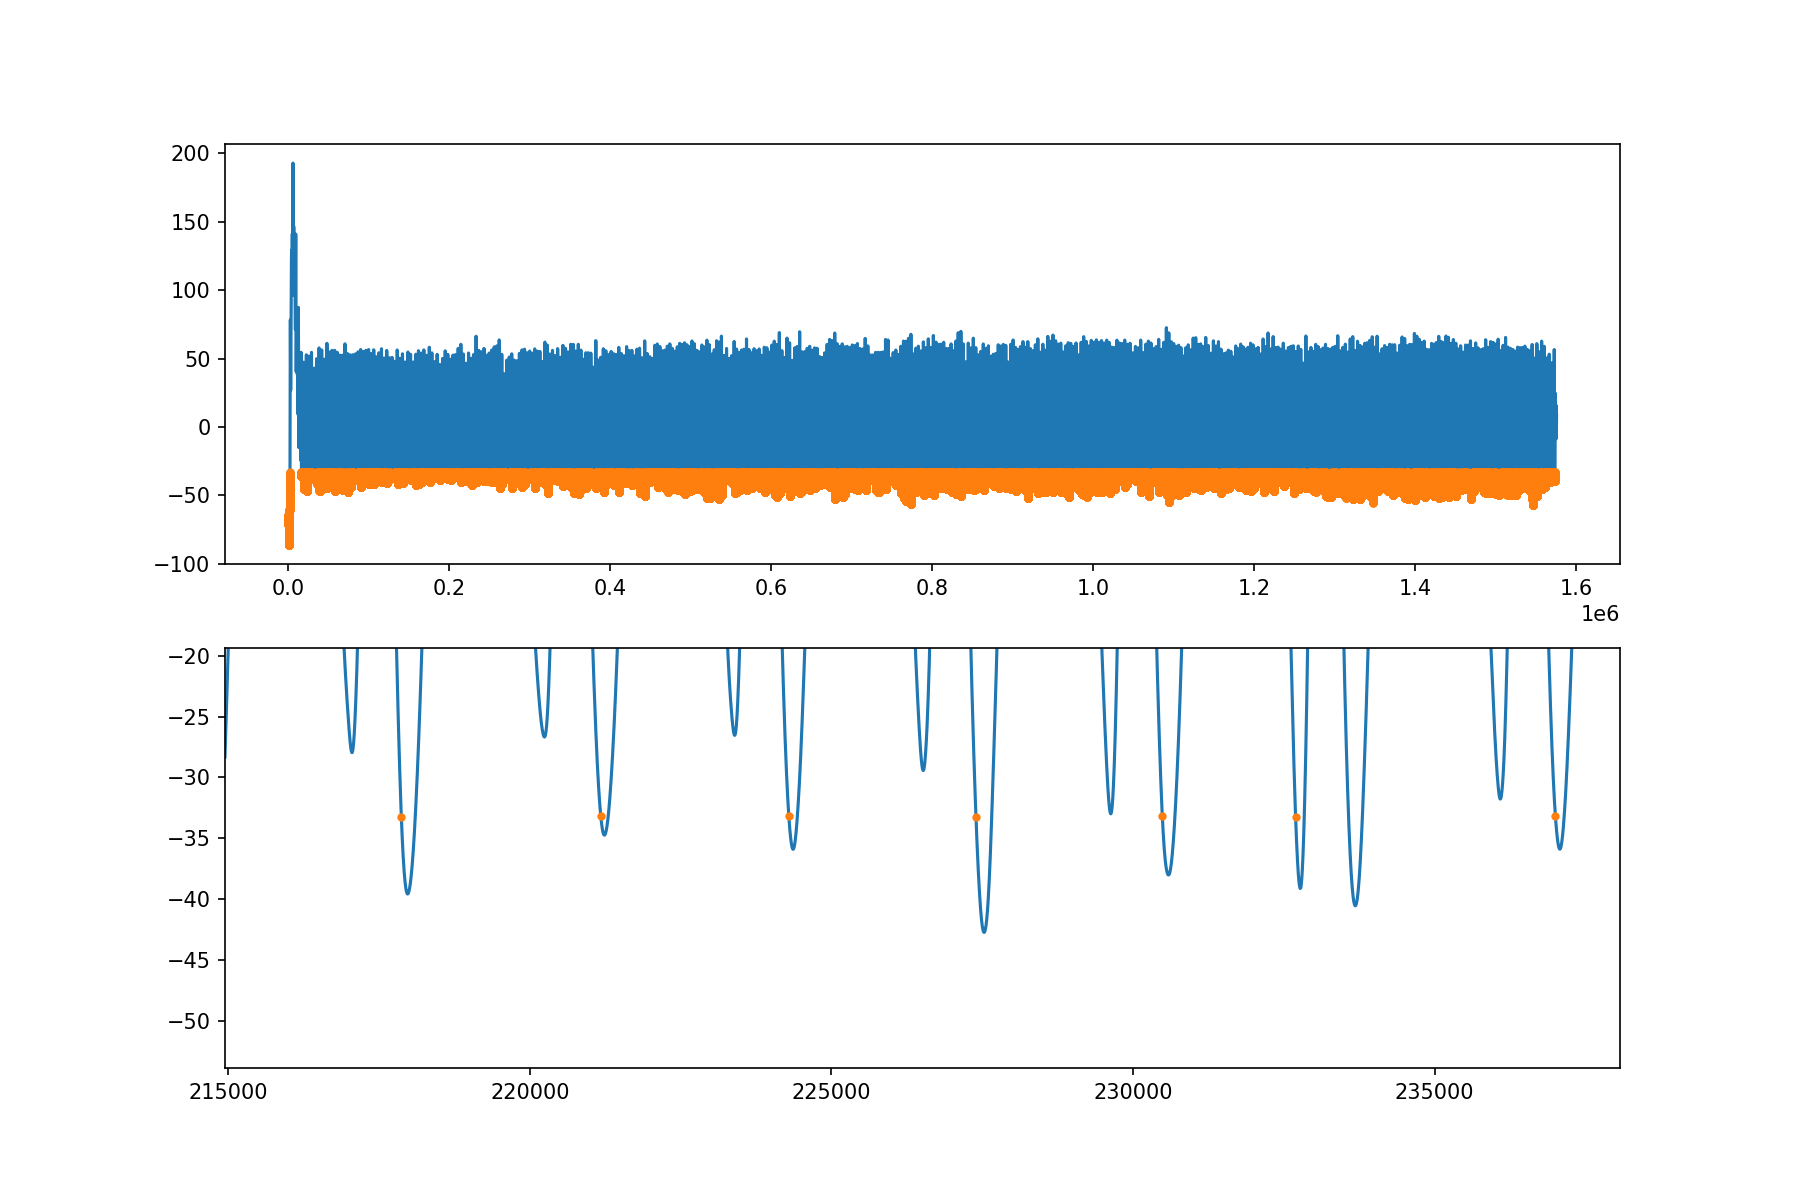

In [35]:
plt.close()
fig,ax=plt.subplots(2,1, figsize=(12,8))
ax[0].plot(out)
ax[0].plot(inds,out[inds], '.')

new_peaks=reduce_peaks(inds, 2000)
ax[1].plot(out)
ax[1].plot(new_peaks,out[new_peaks], '.')

In [51]:
events_min=np.array(events_max)+500

In [52]:
zeros=[0]*len(events_min)
marks=[1]*len(events_min)

ones=np.vstack([events_min,zeros,marks]).T


zeros=[0]*len(events_max)
marks=[2]*len(events_max)

twos=np.vstack([events_max,zeros,marks]).T



In [53]:
len(ones)
len(twos)

499

In [54]:
events=np.vstack([ones,twos])
events

array([[  12683,       0,       1],
       [  16052,       0,       1],
       [  19346,       0,       1],
       ...,
       [1566404,       0,       2],
       [1569543,       0,       2],
       [1572631,       0,       2]])

<IPython.core.display.Javascript object>


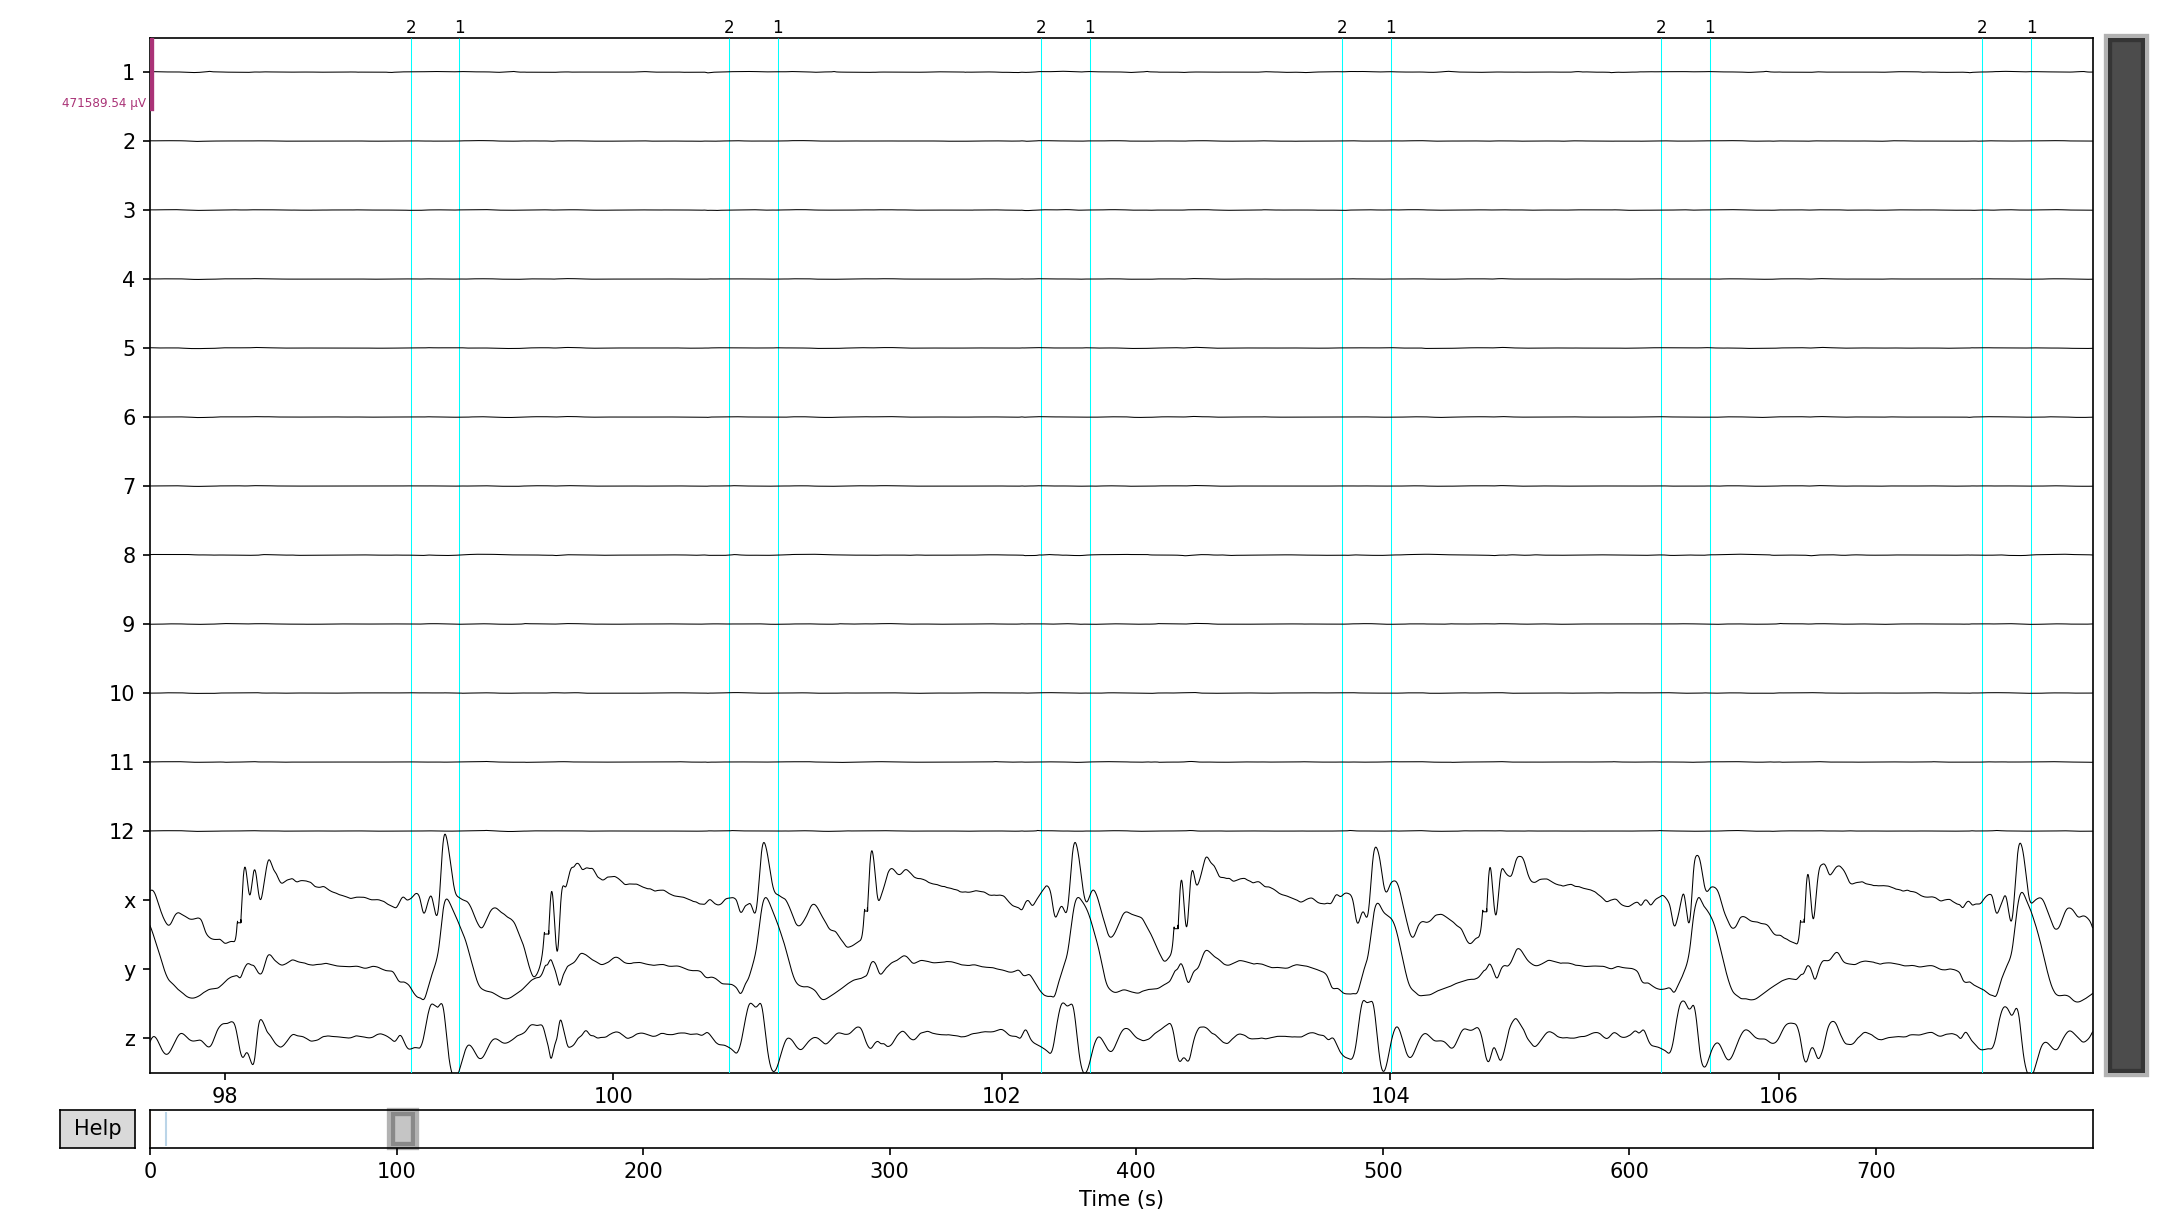

<IPython.core.display.Javascript object>


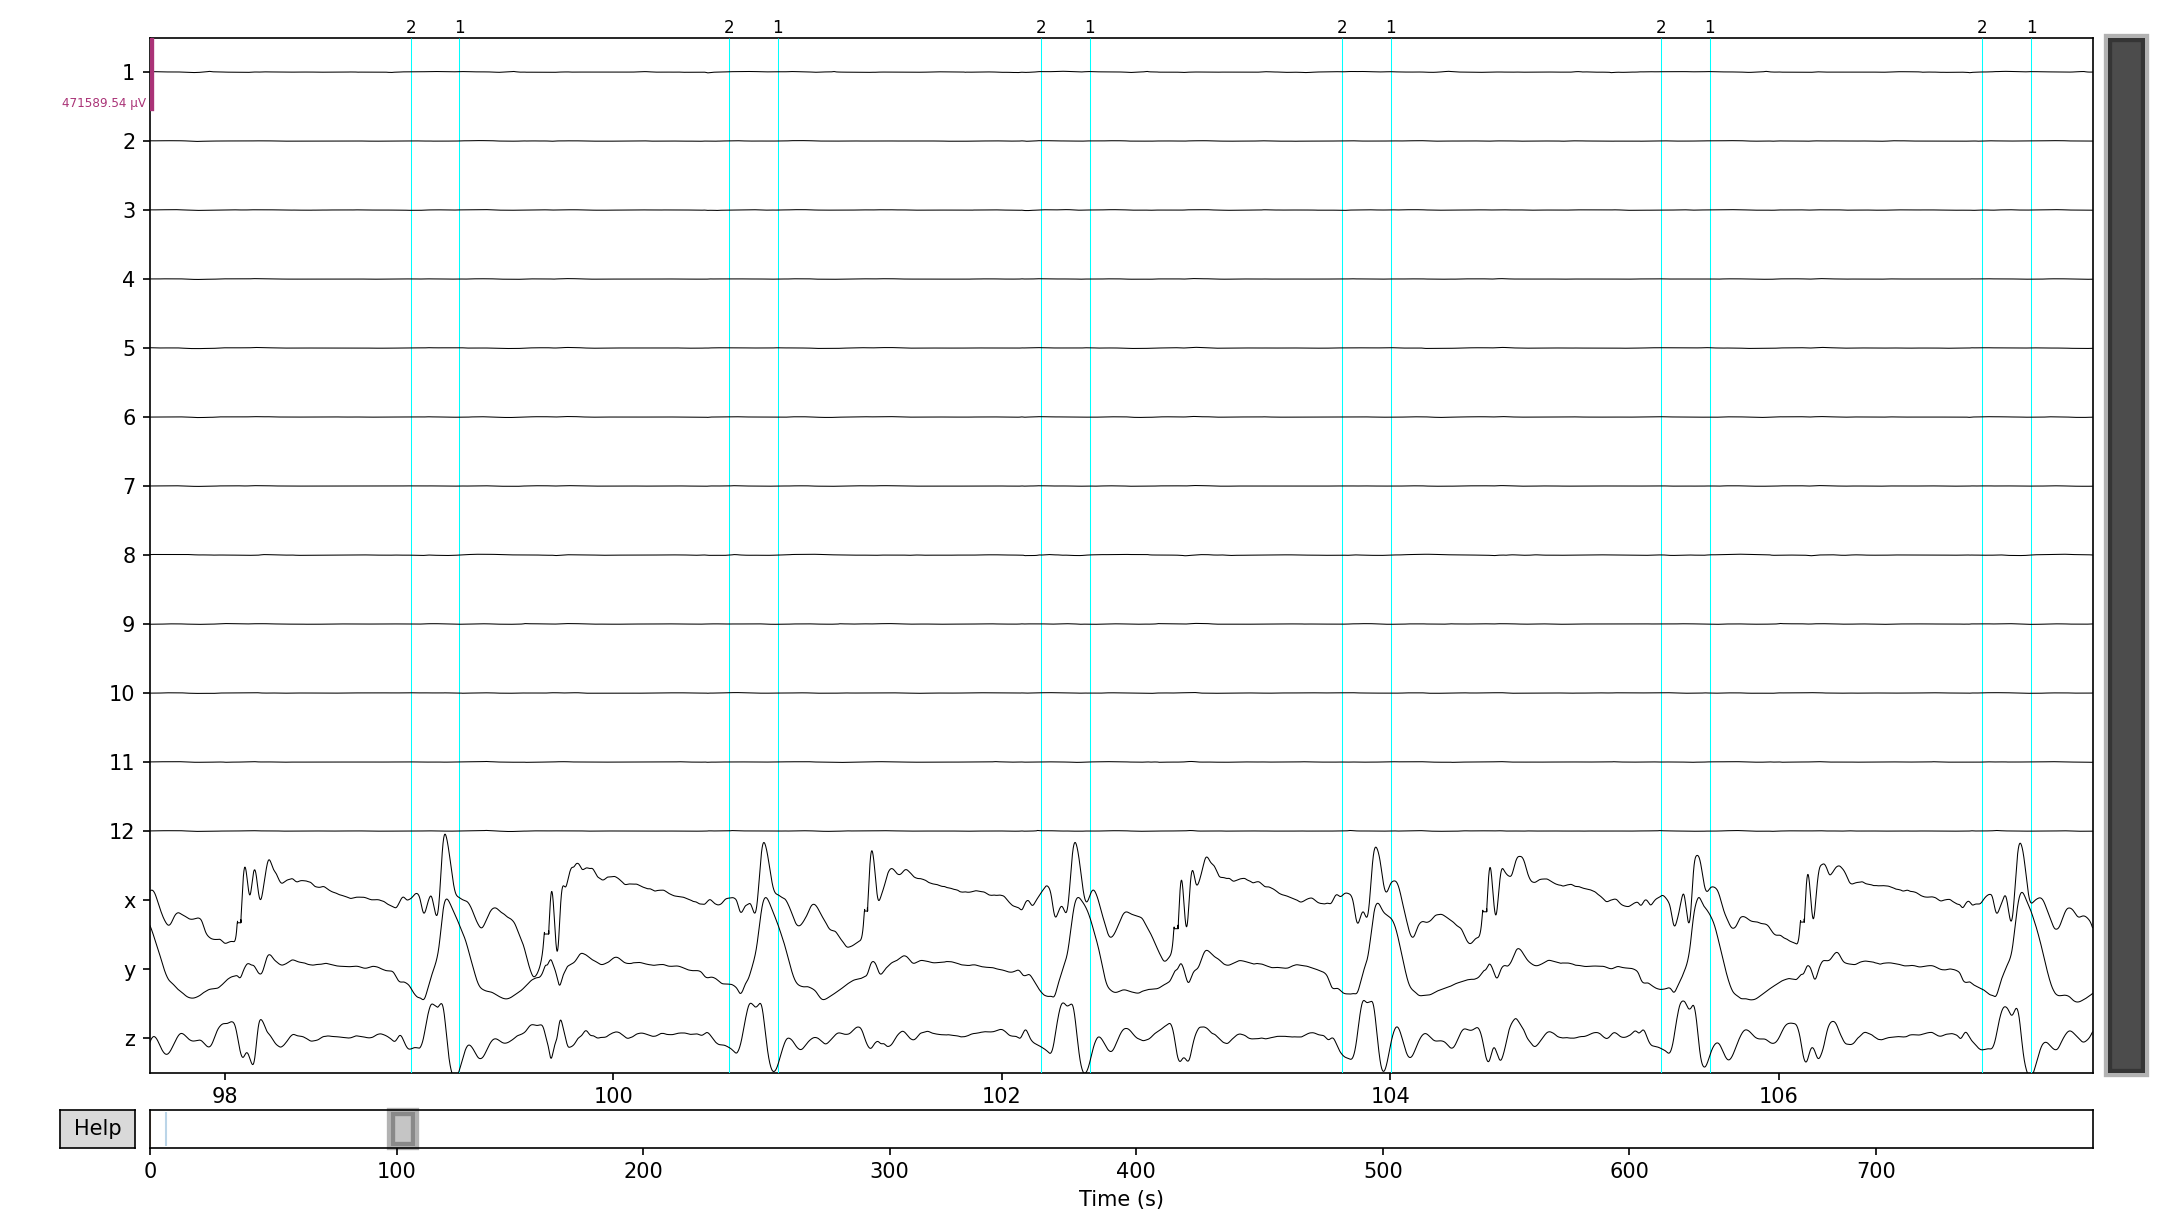

In [55]:
raw_data.plot(events,scalings={'eeg':1e-1})

In [56]:
raw_data_emg=raw_data.copy().drop_channels(['x','y','z'])


SAMPLING_FREQUENCY = raw_data_emg.info['sfreq']
CHANNEL_NUMBER = len(raw_data_emg.ch_names)
BANDPASS_LIMITS = (200, 500)

In [57]:
raw_hil = raw_data_emg.copy().filter(BANDPASS_LIMITS[0], BANDPASS_LIMITS[1]).apply_hilbert(envelope=True).filter(0, 20)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 500.00 Hz
- Upper transition bandwidth: 125.00 Hz (-6 dB cutoff frequency: 562.50 Hz)
- Filter length: 133 samples (0.067 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter l

In [63]:
epochs=mne.Epochs(raw_hil, events=events, tmin=-0.5, tmax=0.1, 
                        preload=True, 
                        baseline=None).apply_hilbert(envelope=True)

Not setting metadata
Not setting metadata
998 matching events found
No baseline correction applied
0 projection items activated
Loading data for 998 events and 1201 original time points ...


/var/folders/2m/6g8qzjcd00n9j42dqh2ndj780000gn/T/ipykernel_20042/4011406920.py:1: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs=mne.Epochs(raw_hil, events=events, tmin=-0.5, tmax=0.1,


0 bad epochs dropped


In [64]:
epochs

Number of events,998
Events,1: 4992: 499
Time range,-0.500 – 0.100 sec
Baseline,off


In [65]:
def get_features_labels(epochs):
    X=[]
    for i in range(epochs._data.shape[0]):
        channel_names = np.arange(CHANNEL_NUMBER).astype(str).tolist()
        channel_types = ['emg']*CHANNEL_NUMBER
        info = mne.create_info(channel_names, SAMPLING_FREQUENCY, channel_types)
        raw = mne.io.RawArray(epochs._data[i], info, verbose=False)
        raw.filter(BANDPASS_LIMITS[0], BANDPASS_LIMITS[1], picks=['emg'], n_jobs=4)
        x__=[]
        # Mean absolute value
        for channel in raw.get_data():
            x__.append(channel.mean())
        # Matematical expactation
        for channel in raw.get_data():
            x__.append(channel.std())
        # Variance
        for channel in raw.get_data():
            x__.append(channel.var())
        # Waveform length
        for channel in raw.get_data():
            x__.append(np.sum(np.diff(channel, n=1)))
        # Number pf peaks
        for channel in raw.get_data():
            x__.append(len(find_peaks(channel)))
        
        # Append PCA of epoch data
        pca = PCA(6)
        pv = pca.fit_transform(epochs._data[i])
                         
        X.append(x__)
    X = np.array(X).squeeze()
    y = epochs.events[:,-1].flatten()
    return X, y


In [66]:

X, y = get_features_labels(epochs)

print('X: ', X.shape)
print('Y: ', y.shape)
#classifier = SVC(C=0.8, kernel='rbf', probability=True)
# cross_val_score(classifier, X, y, cv=3)
#classifier.fit(X, y)
#classifier.score(X, y)

X:  (998, 60)
Y:  (998,)


In [67]:
classifier = SVC(C=0.8, kernel='rbf', probability=True)
#cross_val_score(classifier, X, y, cv=3)
classifier.fit(X, y)
classifier.score(X, y)

0.8366733466933868

In [68]:
events_min

array([  12683,   16052,   19346,   22660,   25810,   29050,   32494,
         35452,   38472,   41670,   44923,   48183,   51440,   54611,
         57836,   61036,   64335,   67359,   70606,   73825,   76995,
         80338,   83575,   86907,   90073,   93258,   96662,   99970,
        103232,  106386,  109593,  112800,  115990,  119303,  122537,
        125819,  129133,  132300,  135561,  138882,  142108,  145336,
        148881,  152136,  155575,  158752,  161989,  165323,  168634,
        172047,  175415,  178577,  181869,  185182,  188486,  191896,
        195201,  198412,  201692,  204904,  208005,  211286,  214596,
        217830,  221055,  224176,  227328,  230407,  233533,  236882,
        240138,  243393,  246600,  249790,  252911,  256077,  259150,
        262264,  265465,  268513,  271596,  274770,  277838,  281067,
        284382,  287379,  290595,  293751,  296892,  300132,  303216,
        306390,  309572,  312795,  315940,  318998,  322135,  325275,
        328509,  331

In [69]:
zeros=[0]*len(events_min)
marks=[3]*len(events_min)

threes=np.vstack([np.array(events_min)+500,zeros,marks]).T

#twos=np.vstack([events_max,zeros,marks]).T



In [70]:

events=np.vstack([ones,twos, threes])


<IPython.core.display.Javascript object>


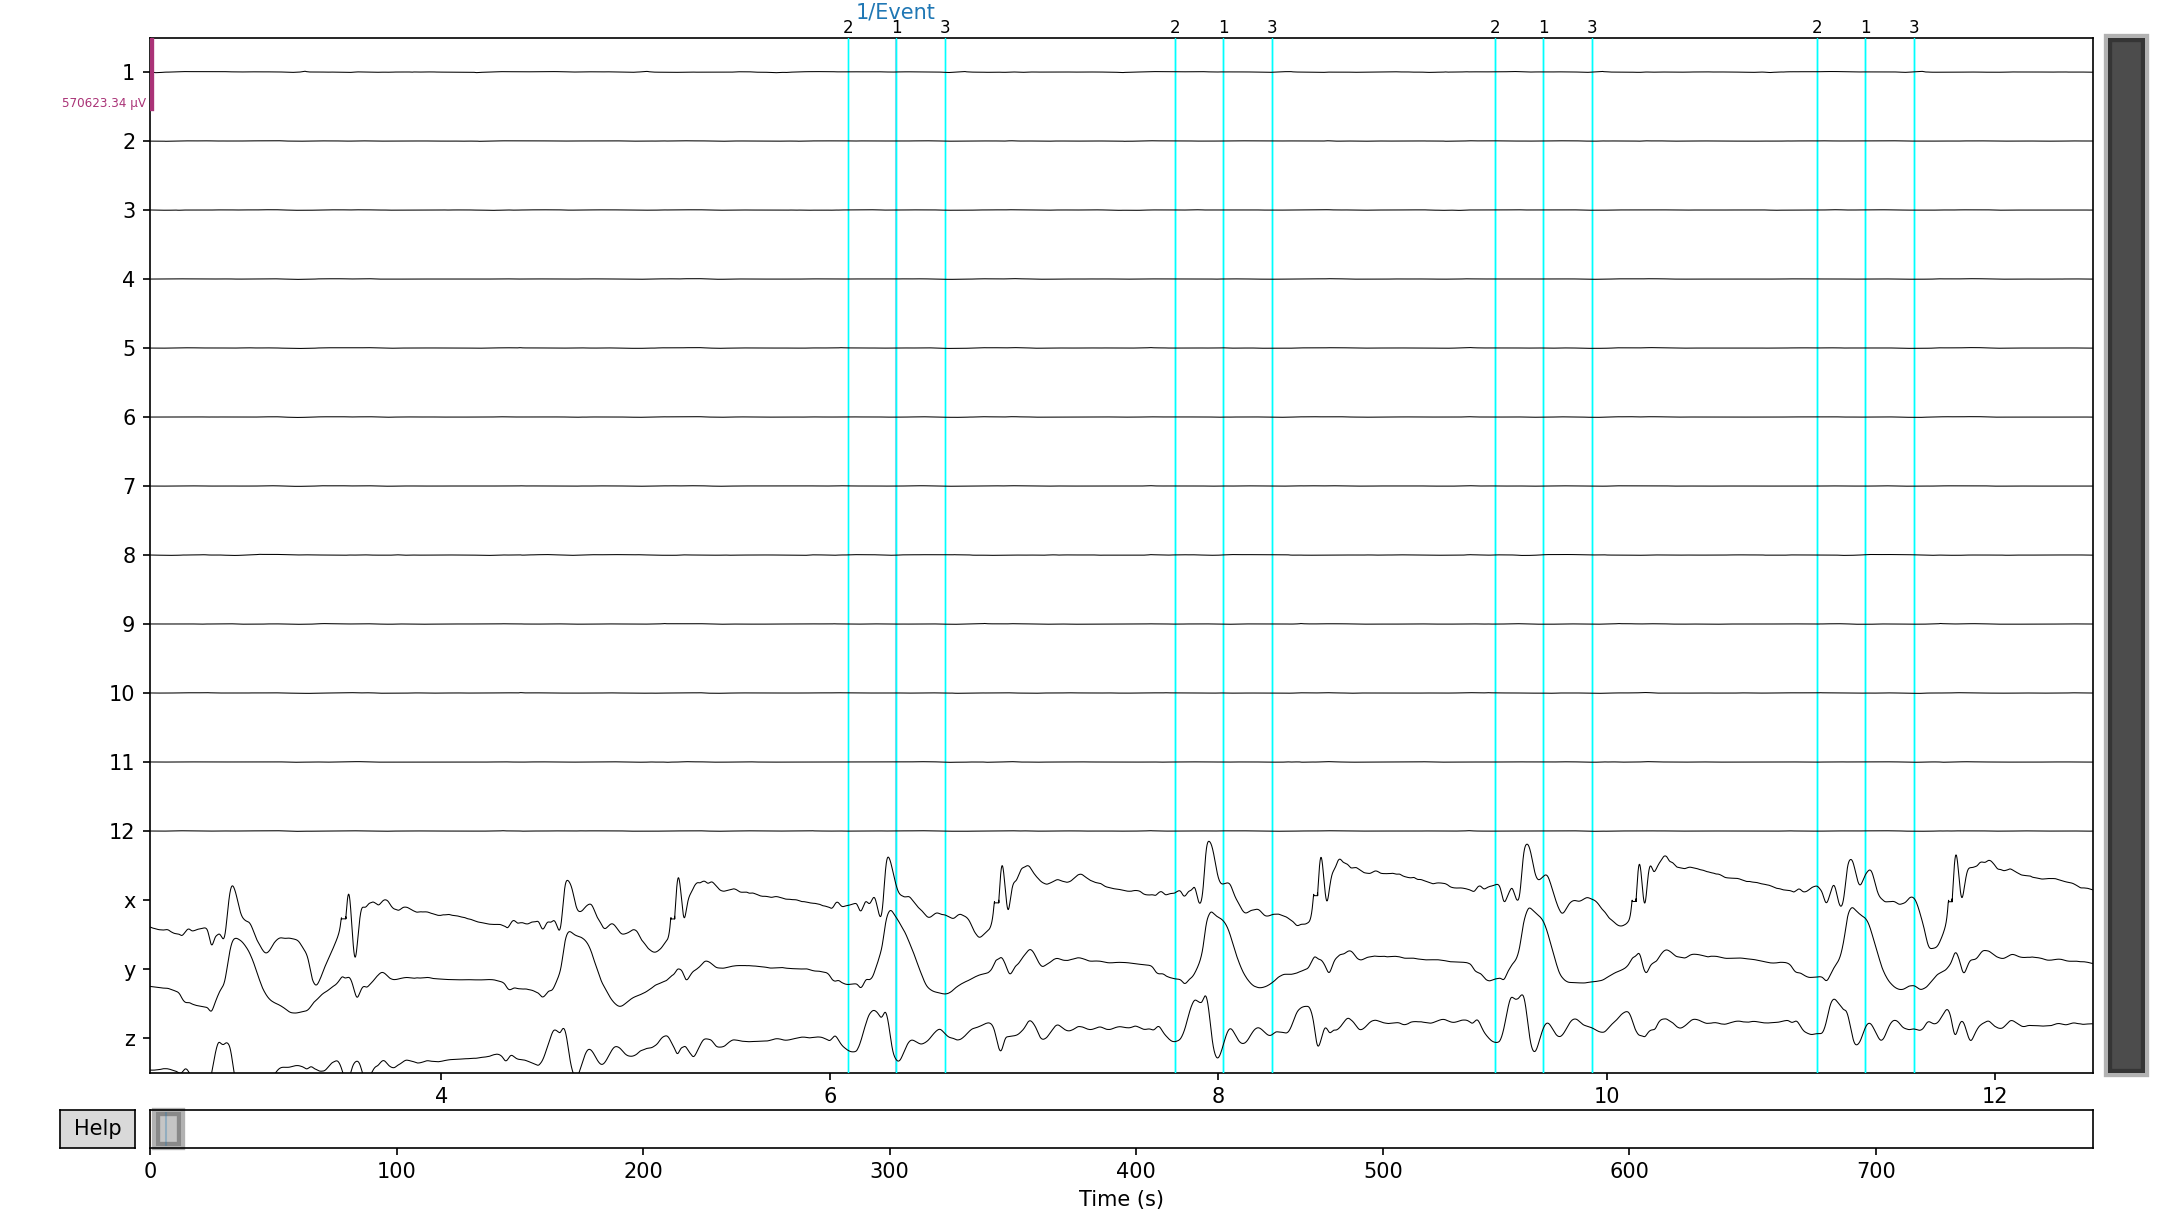

<IPython.core.display.Javascript object>


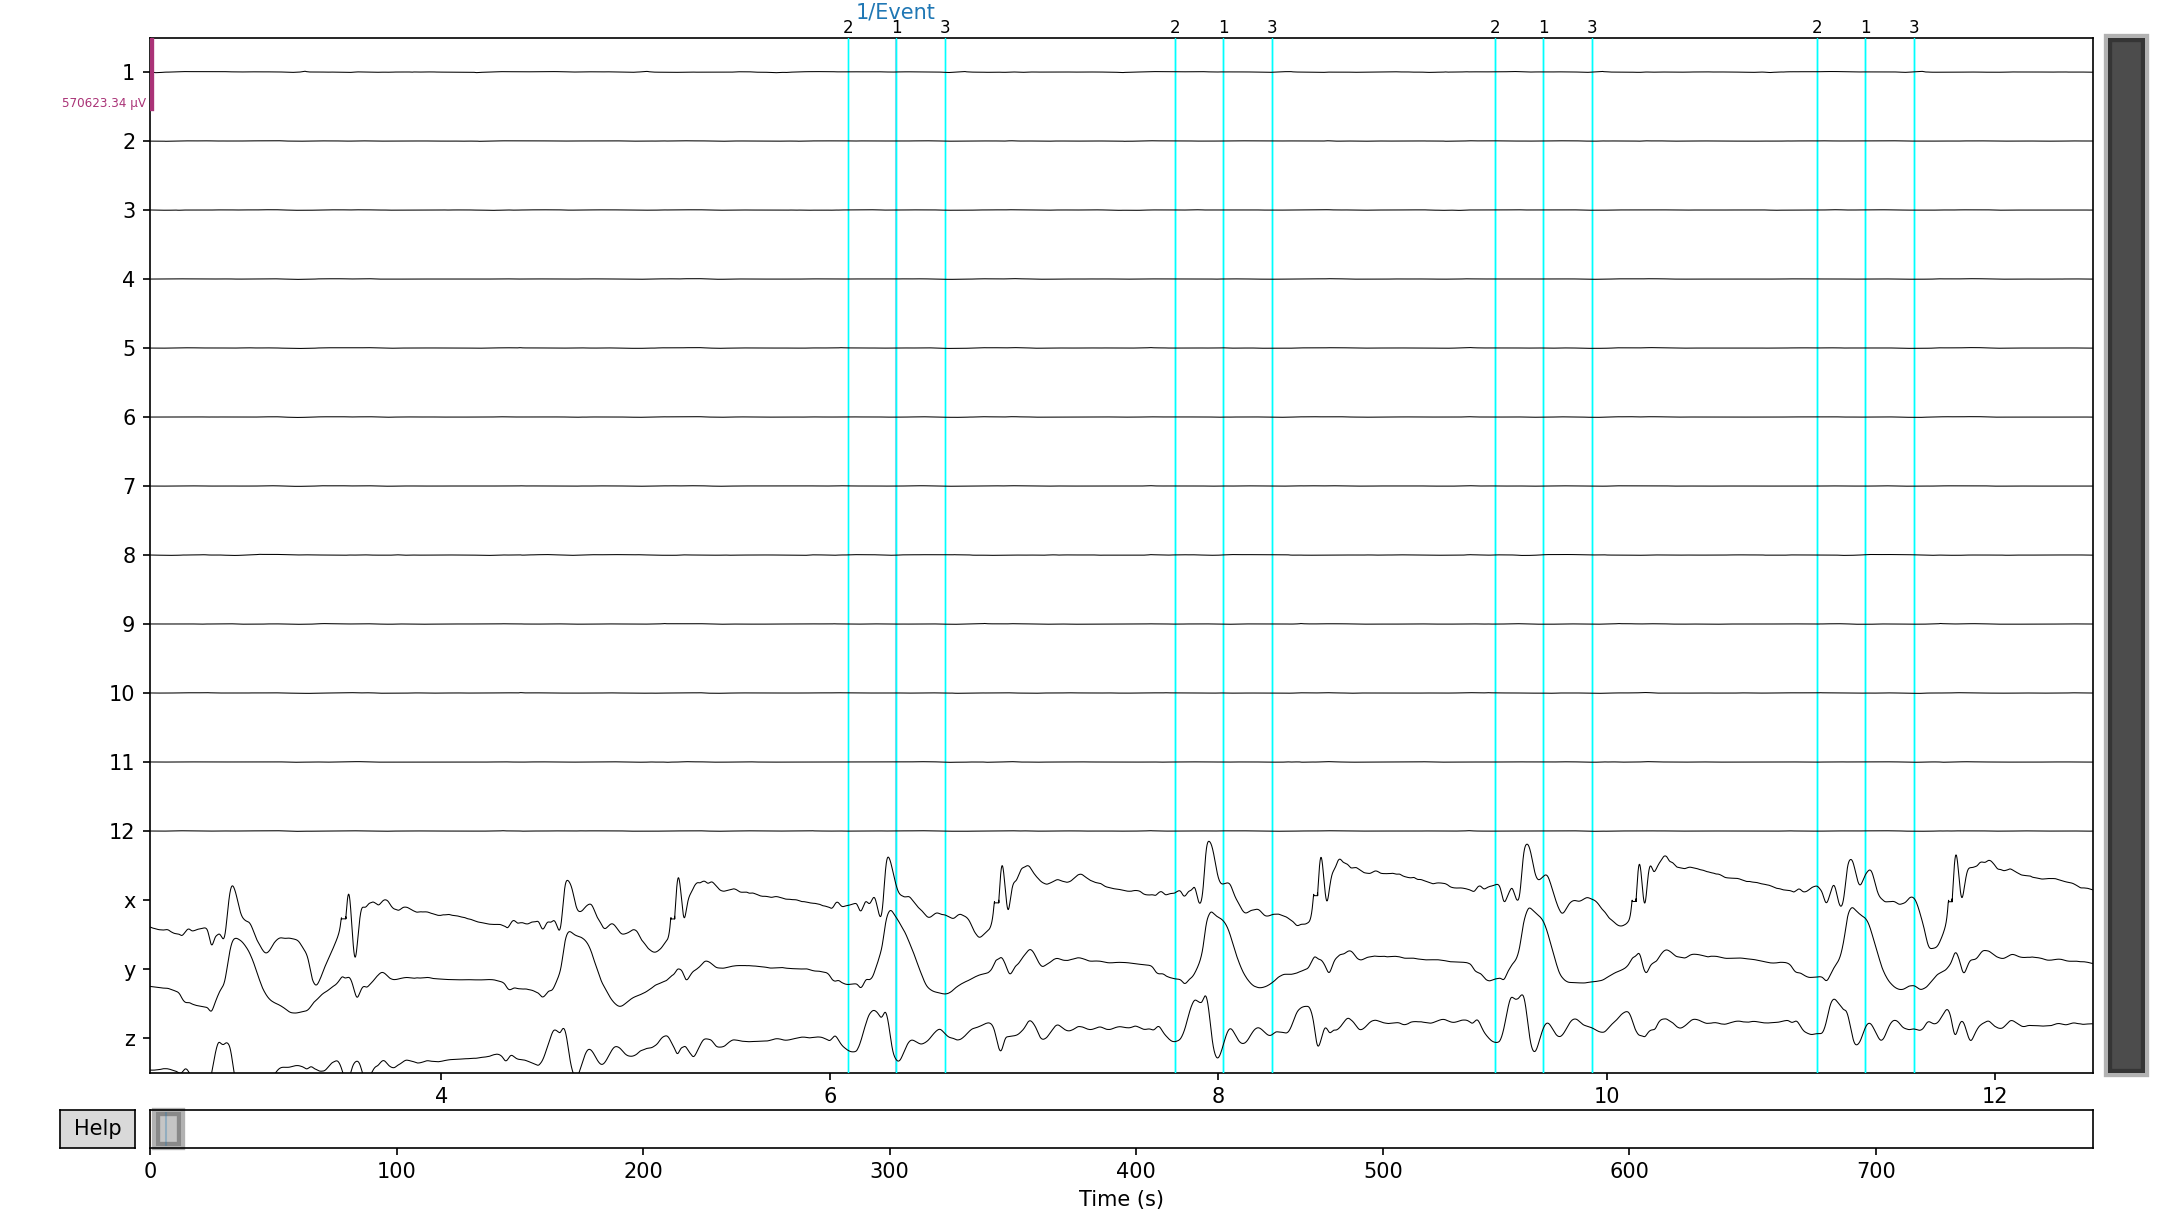

In [71]:
raw_data.plot(events,scalings={'eeg':1e-1})

In [73]:
epochs=mne.Epochs(raw_hil, events=events, tmin=-0.5, tmax=0.0, 
                        preload=True, 
                        baseline=None).apply_hilbert(envelope=True)

Not setting metadata
Not setting metadata
1497 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1497 events and 1001 original time points ...


/var/folders/2m/6g8qzjcd00n9j42dqh2ndj780000gn/T/ipykernel_20042/769227635.py:1: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs=mne.Epochs(raw_hil, events=events, tmin=-0.5, tmax=0.0,


0 bad epochs dropped


In [74]:

X, y = get_features_labels(epochs)

print('X: ', X.shape)
print('Y: ', y.shape)
#classifier = SVC(C=0.8, kernel='rbf', probability=True)
# cross_val_score(classifier, X, y, cv=3)
#classifier.fit(X, y)
#classifier.score(X, y)

X:  (1497, 60)
Y:  (1497,)


In [75]:
classifier = SVC(C=0.8, kernel='rbf', probability=True)
#cross_val_score(classifier, X, y, cv=3)
classifier.fit(X, y)
classifier.score(X, y)

0.6479625918503674

In [76]:
zeros=[0]*len(events_min)
marks=[4]*len(events_min)

fores=np.vstack([np.array(events_min)+1000,zeros,marks]).T

#twos=np.vstack([events_max,zeros,marks]).T



In [77]:

events=np.vstack([ones,twos, threes, fores])


<IPython.core.display.Javascript object>


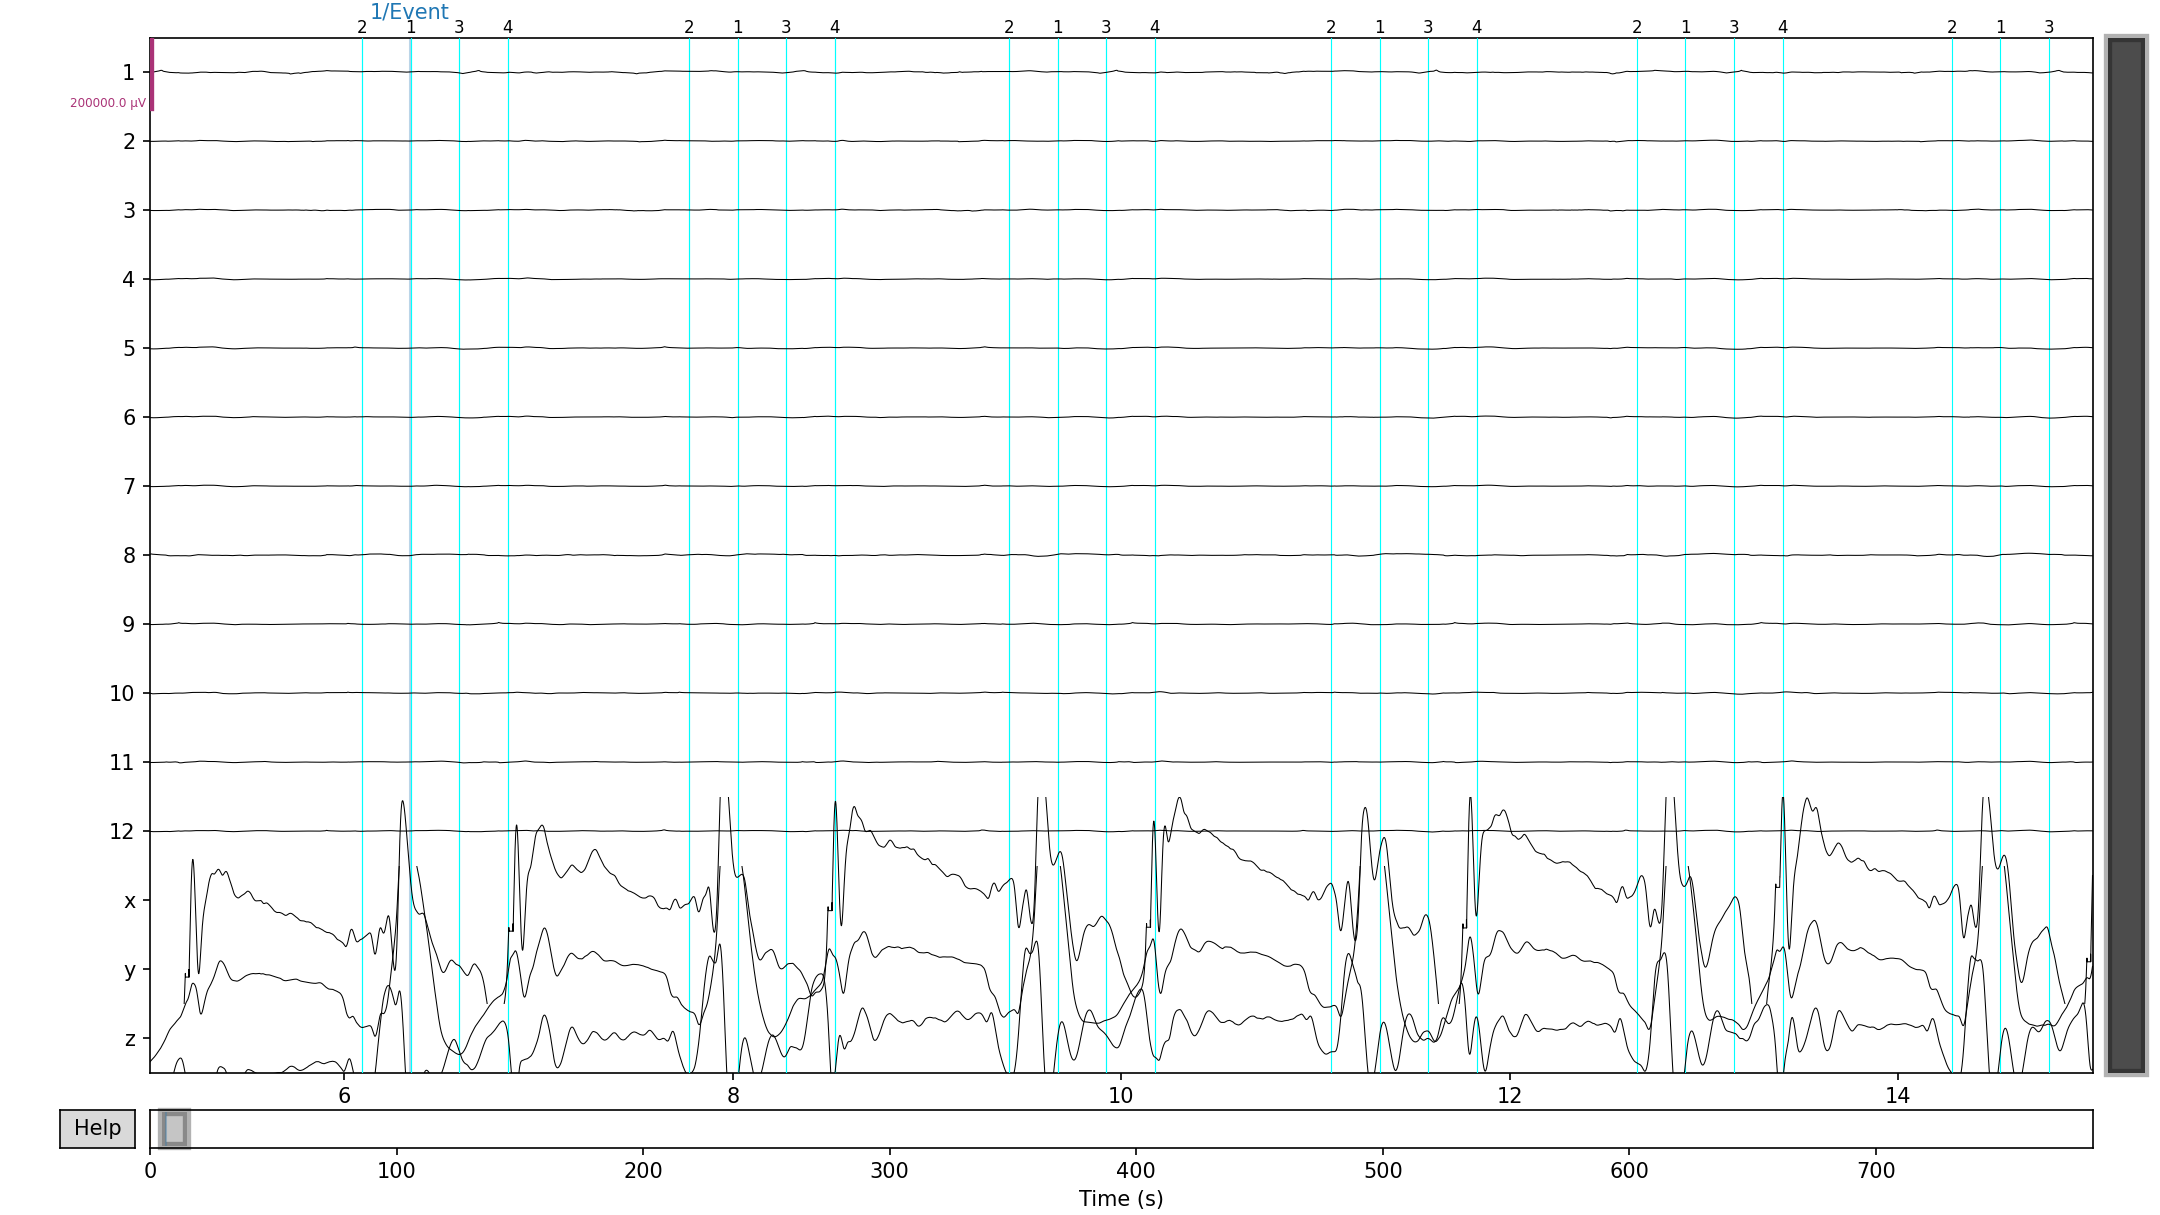

<IPython.core.display.Javascript object>


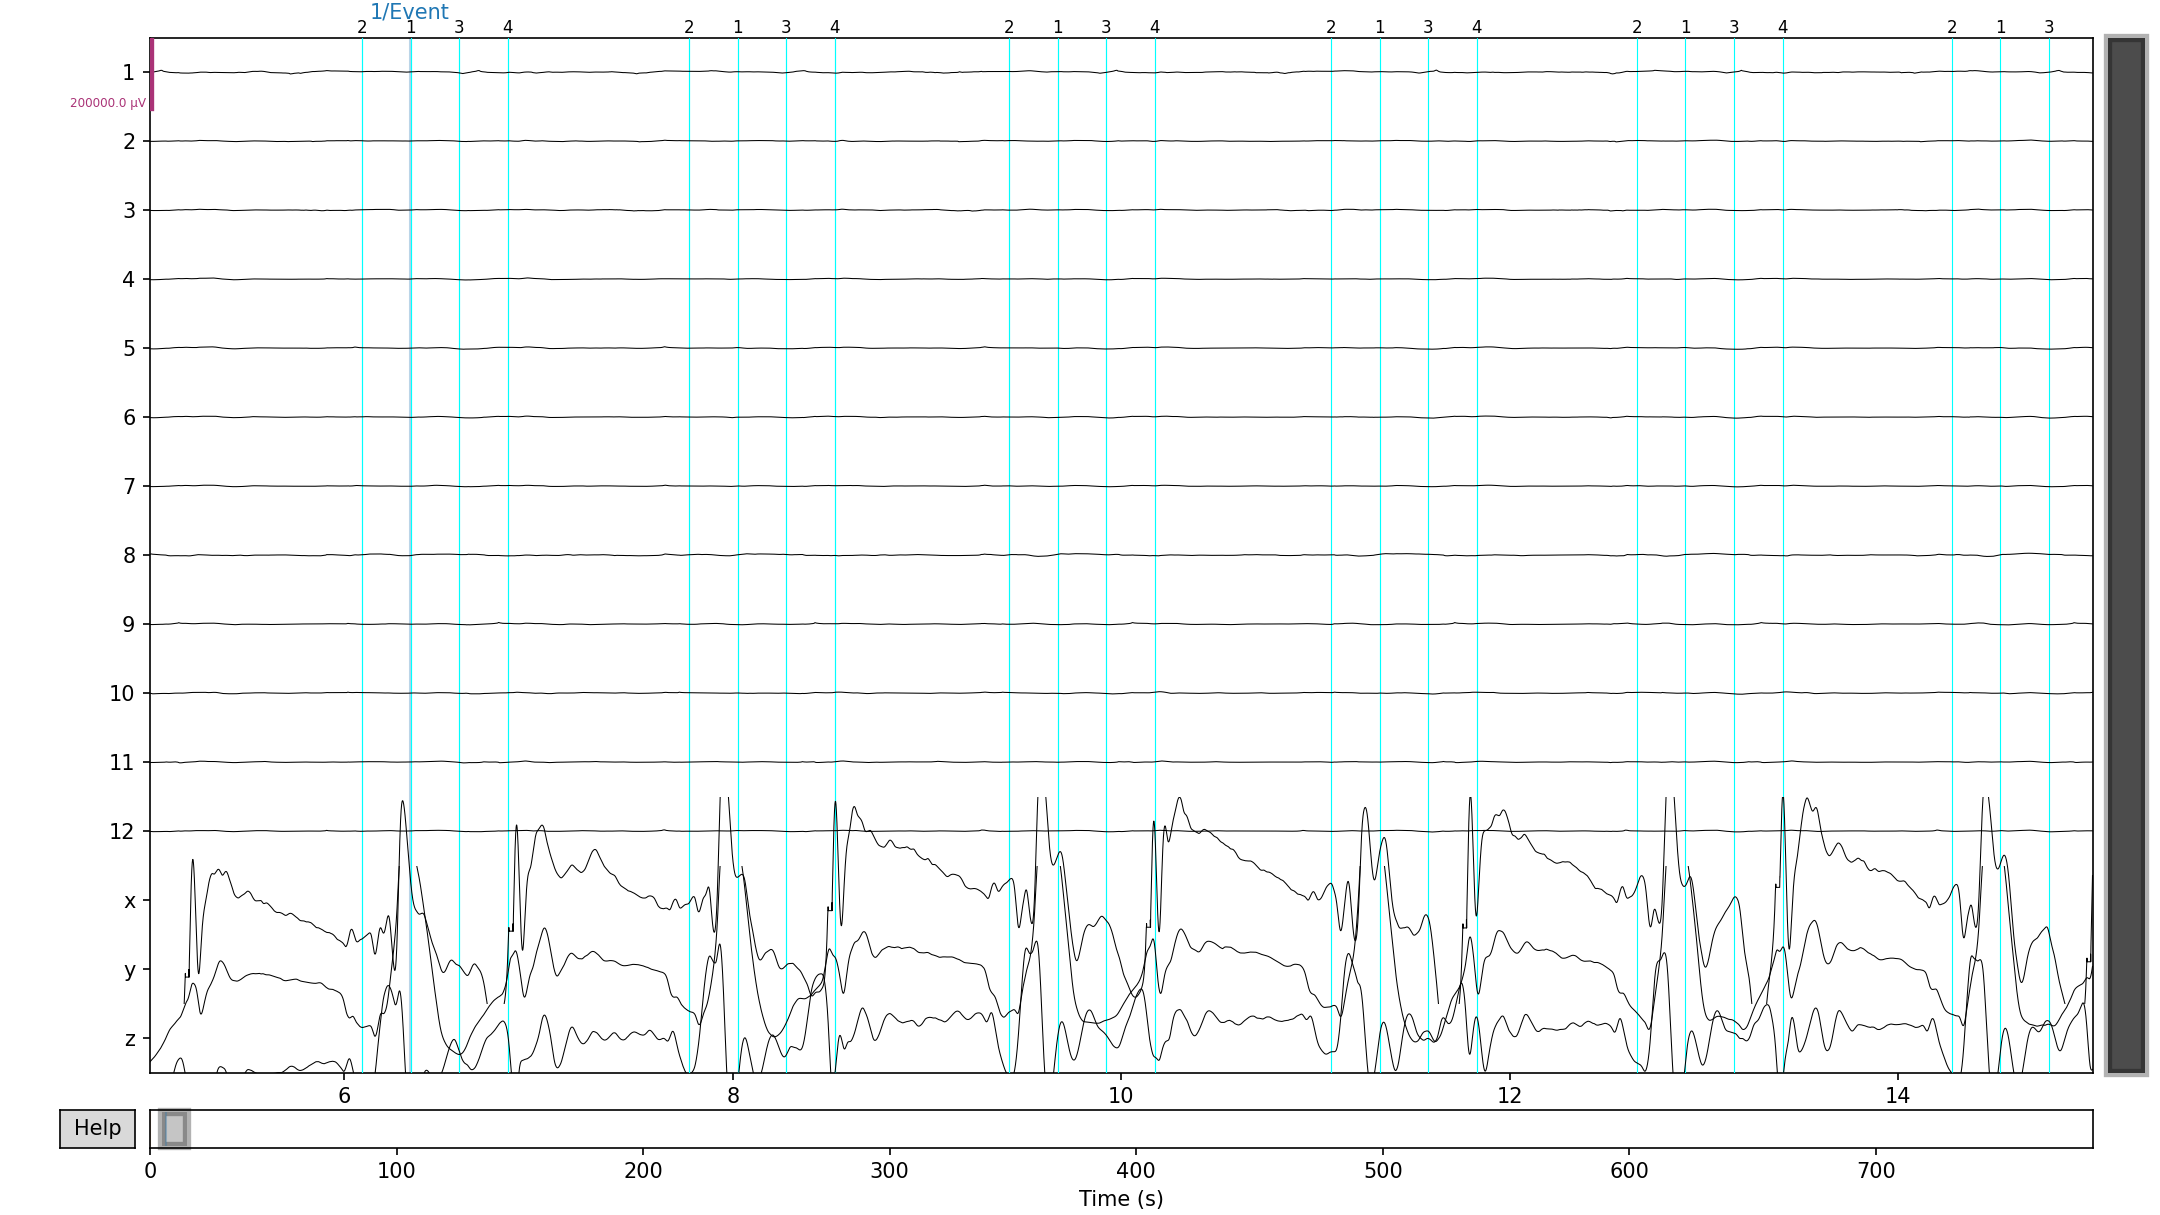

In [78]:
raw_data.plot(events,scalings={'eeg':1e-1})

In [85]:
epochs=mne.Epochs(raw_hil, events=events, tmin=-0.5, tmax=0.0, 
                        preload=True, 
                        baseline=None).apply_hilbert(envelope=True)

Not setting metadata
Not setting metadata
1996 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1996 events and 1001 original time points ...


/var/folders/2m/6g8qzjcd00n9j42dqh2ndj780000gn/T/ipykernel_20042/769227635.py:1: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs=mne.Epochs(raw_hil, events=events, tmin=-0.5, tmax=0.0,


0 bad epochs dropped


In [86]:

X, y = get_features_labels(epochs)

print('X: ', X.shape)
print('Y: ', y.shape)
#classifier = SVC(C=0.8, kernel='rbf', probability=True)
# cross_val_score(classifier, X, y, cv=3)
#classifier.fit(X, y)
#classifier.score(X, y)

X:  (1996, 60)
Y:  (1996,)


In [87]:
classifier = SVC(C=0.8, kernel='rbf', probability=True)
#cross_val_score(classifier, X, y, cv=3)
classifier.fit(X, y)
classifier.score(X, y)

0.5460921843687375

In [ ]:
classifier.predict(X)